# Dino Bektesevic Exoplanets HW 3 
March 1st 2019

In [1]:
import copy
import collections 

import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import astropy.units as u
import astropy.constants as c

import rebound

from IPython.display import display, clear_output

%matplotlib inline

## 1. Familiarize yourself with initializing and running a planetary system

First we define some quantities for our system. I picked GJ 876 to test rebound code on. According to the [manual](https://rebound.readthedocs.io/en/latest/ipython/Units.html) the default units are set such that $G=1$ (i.e. AU, $M_{sun}$, year/$2\pi$ and radians). To that end a series of conversion coefficients are defined.

In [2]:
mjup2msun = (c.M_jup/c.M_sun).value
mearth2msun = (c.M_earth/c.M_sun).value
ms2auyr = (u.m/u.s).to(u.AU/u.yr)
days2yr = u.day.to(u.yr)
deg2rad = 0.0174533

Annoyingly Rebound will not accept parameters like K into their `Particle` class. But we want a way to carry that value and any additional information we might find useful alon with our `Planet`. So we write a class that will do that for us, but will stil lbe easy to use with Rebound.

In [3]:
class Planet(collections.Mapping):
    """Class that represents a planet. 
    
    This is a broader definition than the one used by Rebound to define their particles.
    Namely this class keeps track of parameters like P and K, which rebound can not accept.
    
    To make use with rebound easier, the unpacking operator has been overriden to only return
    values Rebound accepts as well.
    """
    def __init__(self, m, e, a, i, w, M, K, P):
        self.m = m
        self.e = e
        self.a = a
        self.inc = i
        self.omega = w
        self.M = M
        self.K = K  
        self.P = P
        
    def __iter__(self):
        return iter(['m', 'e', 'a', 'inc', 'omega', 'M'])
    
    def __getitem__(self, item):
        return getattr(self, item)
    
    def __len__(self):
        return 1
    
    def __repr__(self):
        retstr = '<{0}.Planet(m={1:.4}, e={2:.4}, a={3:.4}, i={4:.4}, w={5:.4}, M={6:.4}, K={7:.4}, P={8:.4}>'
        return retstr.format(__name__, self.m, self.e, self.a, self.inc, self.omega, self.M, self.K, self.P)

Finally we can define our system following the values read from the Rivera et. al. [paper](https://arxiv.org/pdf/1006.4244.pdf) 

In [4]:
star = {"m":0.334}

pd = Planet(m=6.83*mearth2msun, e=0.20700, a=0.02080665, i=1.02974, w=4.08,  M=6.2,  K=6.56, P=1.93778*days2yr) 
pc = Planet(m=0.7142*mjup2msun, e=0.25591, a=0.12959000, i=1.02974, w=0.851, M=5.14, K=88.34,P=30.0881*days2yr)
pb = Planet(m=2.2756*mjup2msun, e=0.03240, a=0.20831700, i=1.02974, w=0.878, M=5.68, K=214,  P=61.1166*days2yr)
pe = Planet(m=14.6*mearth2msun, e=0.05500, a=0.33430000, i=1.02974, w=4.17,  M=5.85, K=3.42, P=124.260*days2yr)

# order matters if inserting through a for loop!
planets = [pd, pc, pb, pe]

Add the planets to the simulation and plot it to see initial state.

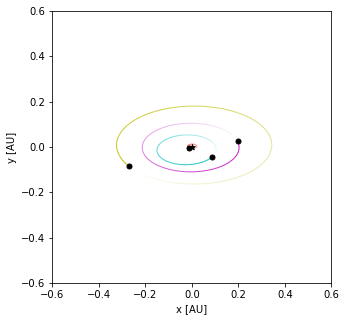

In [5]:
sim = rebound.Simulation()

sim.add(**star)
for planet in planets:
    sim.add(**planet)
sim.move_to_com()

fig = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]",lim=0.6)

Check if integrating the system produces a stable result or if the system seems to be unstable. This is useful to verify that the provided values make sense and are not in the wrong units or that there was a mistake made when converting.

Considering the default unit system used, a single timestep is in reference to $dt=yr/2\pi = 365.256/2\pi = 58.1323$ days. The period of the innermost planet is ~2 days. So a good timestep to use is given as $P/20 ~ 0.1days$ or $0.00172021412dt$. 

A 1000 orbits of the innermost planet takes approximately 2000 days or approximately 5.5 years. Starting from $t=0$ we need to integrate to $t=11\pi$ to get 2000 orbits of closest planet. Note that since this is a reccuring timespan and timestep we declare an array `t` that we can reference later if we ever need it to make a plot.

In [6]:
semmajs = {'d':[], 'c':[], 'b':[], 'e':[]}
es = {'d':[], 'c':[], 'b':[], 'e':[]}
dt = 0.00172021412

while sim.t<11*np.pi:
    sim.integrate(sim.t+dt)
    for name, particle in zip('dcbe', sim.particles[1:]):
        semmajs[name].append(particle.a)
        es[name].append(particle.e)

Plot the results and verify

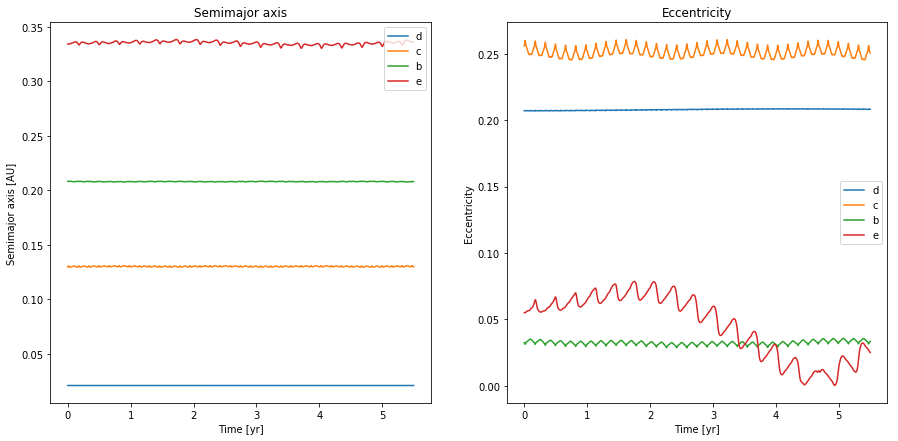

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

t = np.arange(0, sim.t, dt)

for key, val in semmajs.items():
    axes[0].plot(t/(2*np.pi), val, label=key)
axes[0].set_title('Semimajor axis')
axes[0].set_ylabel('Semimajor axis [AU]')
    
for key, val in es.items():
    axes[1].plot(t/(2*np.pi), val, label=key)
axes[1].set_title('Eccentricity') 
axes[1].set_ylabel('Eccentricity')

for ax in axes:
    ax.set_xlabel('Time [yr]')
    ax.legend()

## 2. Look up the parameters of the planet system GJ 876.  Assume the planets’ orbits lie in a plane, and vary the inclination of the system. 

Essentially the above needs to be repeated for a variety of inclinations. Unfortunatelly because of the observational degeneracy between mass and inclinations, every time we change our assumed inclination we need tochange the planetary masses if we want to be consistent. Luckily the system I picked in problem 1 to familiarize myself with Rebound is the exact same one we are required to simulate in problem 2. How fortuitous.

In [5]:
def calcMass(planet, i, mstar=star['m']):
    """For a given Planet instance, target inclination and stellar mass, recalculates the mass 
    of the planet such that the system remains anologous to the one from Rivera et. al. paper.
    Stelar mass is, by default, set to the Rivera et. al. values.
    """
    # note that in declaring the planets parameters we did not convert K to the rebound units 
    # because the dimensions would not work out
    A = planet.m * np.sin(planet.inc) / (mstar + planet.m)**(2/3)
    mnew = planet.m
    for t in range(100):
        B = (mstar + mnew)**(2/3) / np.sin(i)
        m_new = A * B
    return m_new

The three steps described in problem 1 are wrapped into a function which will reduce ammoutn of code.

In [9]:
def simulate(planets, dt=0.00172021412, tmax=11*np.pi):
    """For given planets, timestep dt and total simulated time tmax runs a Rebound simulation
    and returns dictionary of semimajor axes for every timestep.
    """
    sim = rebound.Simulation()

    sim.add(**star)
    for planet in planets:
        sim.add(**planet)
    sim.move_to_com()

    a = {'d':[], 'c':[], 'b':[], 'e':[]}
    
    while sim.t<tmax:
        sim.integrate(sim.t+dt)
        for name, particle in zip('dcbe', sim.particles[1:]):
            a[name].append(particle.a)
            
    return a

Now we can perform a gridsearch over all of the inclinations of interest.

In [10]:
semmajs = []
for i in range(1, 90):
    pplan = copy.deepcopy(planets)
    for planet in pplan:
        newm = calcMass(planet, i*deg2rad)
        planet.inc = i*deg2rad
        planet.m = newm

    semmajs.append(simulate(pplan))

Since I have no better ideas about testing orbit stability I will create plots of all semimajor axes over time and pick the inclinations that have stabile, well separated semimajor axes and label the rest as unstable.

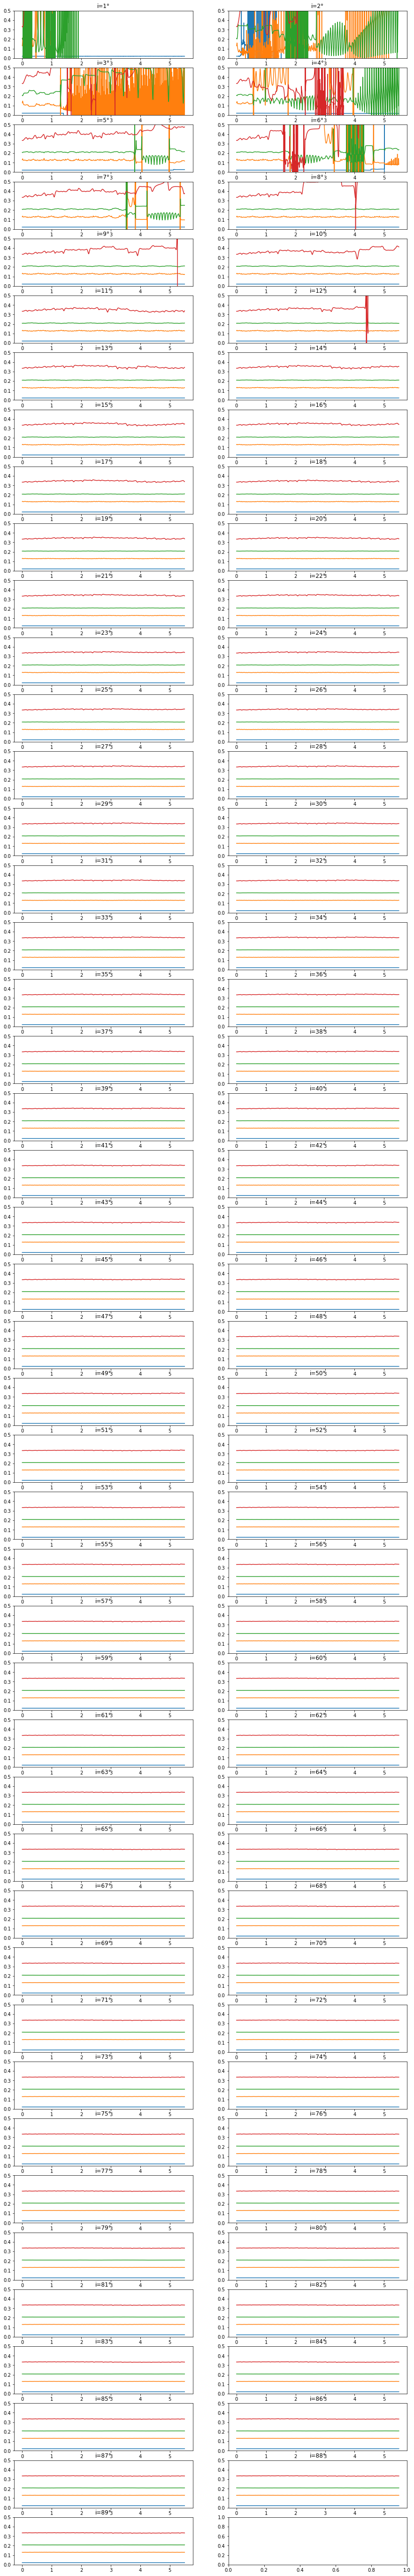

In [11]:
fig, axes = plt.subplots(45, 2, figsize=(15, 100))

i = 1
for ax, model in zip(axes.flatten(), semmajs):
    for pname, pa in model.items():
        ax.plot(t/(2*np.pi), pa, label=pname)
        ax.set_ylim(0, 0.5)
    ax.set_title(f'i={i}°')
    i+=1

### 2.1 At what inclination does the system become unstable after 1000 orbits of the inner planet?

There are several different inclinations at which it would seem the system becomes unstable and they seem to be somewhat mixed with the stable orbits. Up to 13 degrees inclination most of the orbits seem unstable so we focus on that part in more details. Specifically we focus on the $[8, 13>$ range of inclinations since all inclinations prior to 8 degrees seem unstable.

In [14]:
semmajs = []
for i in np.arange(8, 13, 0.05):
    pplan = copy.deepcopy(planets)
    for planet in pplan:
        newm = calcMass(planet, i*deg2rad)
        planet.inc = i*deg2rad
        planet.m = newm

    semmajs.append(simulate(pplan))

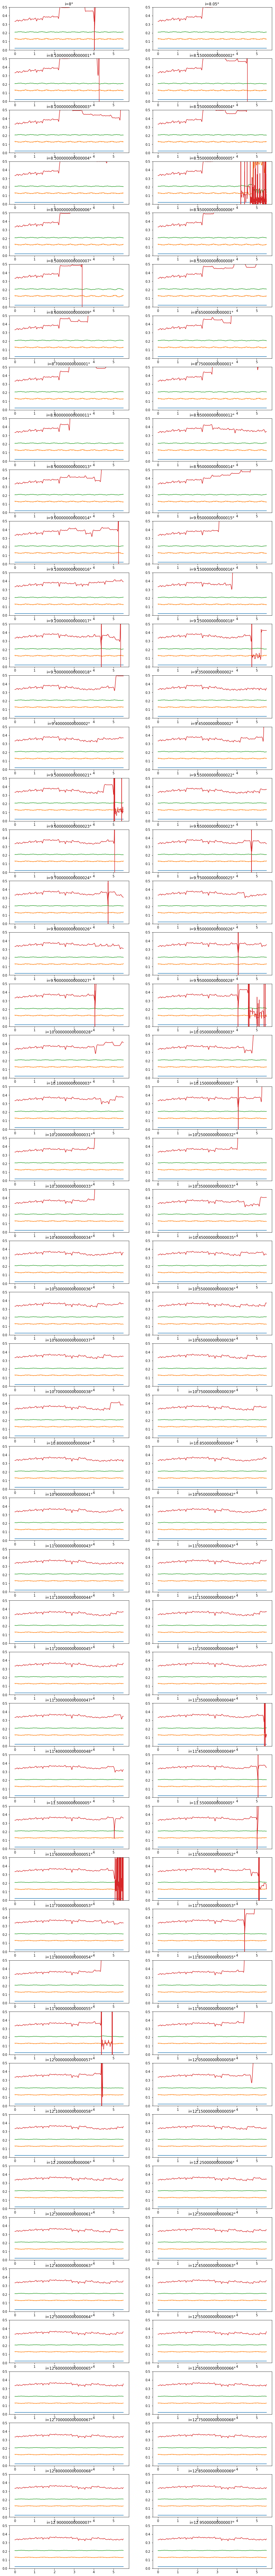

In [17]:
fig, axes = plt.subplots(50, 2, figsize=(15, 150))

i = 8
for ax, model in zip(axes.flatten(), semmajs):
    for pname, pa in model.items():
        ax.plot(t/(2*np.pi), pa, label=pname)
        ax.set_ylim(0, 0.5)
    ax.set_title(f'i={i}°')
    i+=0.05

### 2.2 What upper limit does this place on the planets’ masses?

There seems to be a lonely inclination that produces a stabile configuration at 9.1 degree of inclination but I'll ignore that singular occurence and say the first occurence of stabile orbits occurs above 9.3 degrees of inclination where a small island of stable orbits exists and then all orbits after 12.1 degrees of inclination seem to be stabile. 

In [20]:
for i in [9.35, 12.1]:
    pplan = copy.deepcopy(planets)
    for planet, name in zip(pplan, 'dcbe'):
        newm = calcMass(planet, i*deg2rad)
        print("Mass of planet {0} at inclination {1} is {2} M_sun.".format(name, i, newm))
    print()

Mass of planet d at inclination 9.35 is 0.00010823093456628284 M_sun.
Mass of planet c at inclination 9.35 is 0.0035970233856512128 M_sun.
Mass of planet b at inclination 9.35 is 0.011460916292898206 M_sun.
Mass of planet e at inclination 9.35 is 0.0002313574882383206 M_sun.

Mass of planet d at inclination 12.1 is 8.388443063953751e-05 M_sun.
Mass of planet c at inclination 12.1 is 0.002787874464094785 M_sun.
Mass of planet b at inclination 12.1 is 0.008882787917241798 M_sun.
Mass of planet e at inclination 12.1 is 0.000179313717033272 M_sun.



### 2.3 At what inclination would the planets be seen to transit?

If we assume a grazing passage by the outmost planet in a planar system, which would mean that all interior planets are transiting with a lower impact parameter, we can express the angle of inclination over the sum of the radii of the star and the outmost planet as:

$$\begin{align}
i &= \arccos{\frac{R_s+R_p}{a_p}} \\
i &\approx \arccos{\frac{R_s}{a_p}}
\end{align}$$

In [25]:
rsun2au = 0.00465
rs = 0.3 * rsun2au

i = np.arccos(rs/planets[-1].a)

pplan = copy.deepcopy(planets)
for planet, name in zip(pplan, 'dcbe'):
    newm = calcMass(planet, i*deg2rad)
    print("Mass of planet {0} at inclination {1} is {2} M_sun.".format(name, i, newm))

Mass of planet d at inclination 1.56662341609022 is 0.0006431662290999356 M_sun.
Mass of planet c at inclination 1.56662341609022 is 0.021375441099205778 M_sun.
Mass of planet b at inclination 1.56662341609022 is 0.06810690810046578 M_sun.
Mass of planet e at inclination 1.56662341609022 is 0.0013748502115459825 M_sun.


## 3. Compute the radial velocity of the star, and then fit this RV with four Keplerian orbits.   How big are the residuals?  How does this compare to typical RV errors?

In [35]:
sim = rebound.Simulation()

sim.add(**star)
for planet in planets:
    sim.add(**planet)
sim.move_to_com()

rv = []
    
while sim.t<11*np.pi:
    sim.integrate(sim.t+dt)
    rv.append(sim.particles[0].vz)

Text(0, 0.5, '$R_v$')

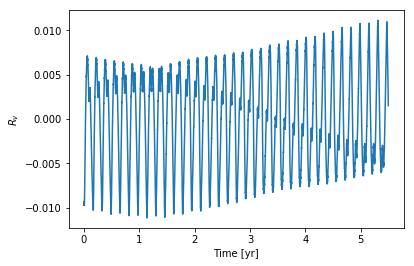

In [45]:
plt.plot(t/(2*np.pi), rv)
plt.xlabel('Time [yr]')
plt.ylabel(r'$R_v$')

## 4. Make a plot of the TTVs of GJ 876 c over 4 years (assuming edge-on, so that planet would transit). 

In [6]:
def calcTTV(planets, N=600, dt=0.00172021412):
    """For given planets, number of transits and timestep dt runs a Rebound
    simulation keeping track of times when transits occur. Returns the transit
    number and simulated transit timing variation of that transit. 
    """
    sim = rebound.Simulation()
    sim.add(**star)
    for planet in pplan:
        sim.add(**planet)
    sim.move_to_com()

    transittimes = np.zeros(N)
    p = sim.particles

    i = 0
    while i<N:
        y_old = p[3].y - p[0].y  # (Thanks to David Martin for pointing out a bug in this line!)
        t_old = sim.t
        sim.integrate(sim.t+dt) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
        t_new = sim.t
        if y_old*(p[3].y-p[0].y)<0. and p[3].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
            while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
                if y_old*(p[3].y-p[0].y)<0.:
                    t_new = sim.t
                else:
                    t_old = sim.t
                sim.integrate( (t_new+t_old)/2.)
            transittimes[i] = sim.t
            i += 1
            sim.integrate(sim.t+dt/10)       # integrate 0.05 to be past the transit
        
    A = np.vstack([np.ones(N), range(N)]).T
    c, m = np.linalg.lstsq(A, transittimes)[0]
    
    return np.asarray(range(N)), np.asarray((transittimes-m*np.array(range(N))-c)*(24.*365./2./np.pi))

In [7]:
pplan = copy.deepcopy(planets)
inc = np.pi/2
for planet in pplan:
    newm = calcMass(planet, inc)
    planet.inc = inc
    planet.m = newm

x1, y1 = calcTTV(pplan)

/home/dinob/anaconda3/envs/exoplanets/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Text(0, 0.5, 'TTV [hours]')

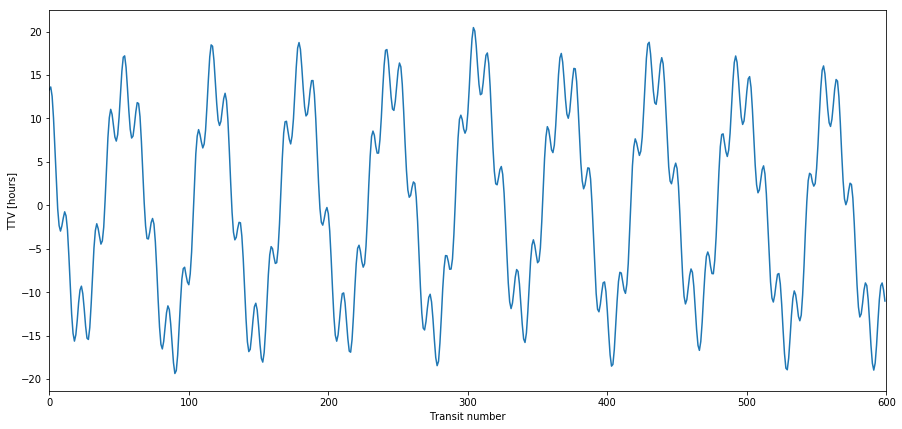

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.plot(x1, y1);

ax.set_xlim([0, 600])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")

### 3.1 How does it change if you vary the mass of GJ 876 b downward and upward by a factor of 2?

/home/dinob/anaconda3/envs/exoplanets/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Text(0, 0.5, 'TTV [hours]')

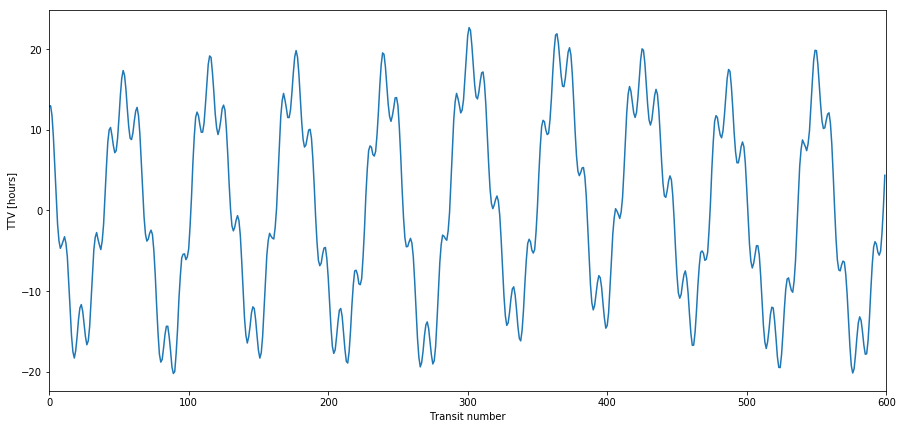

In [9]:
pplan[3].m *= 2

x2, y2 = calcTTV(pplan)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(x2, y2);
ax.set_xlim([0, 600])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")

/home/dinob/anaconda3/envs/exoplanets/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Text(0, 0.5, 'TTV [hours]')

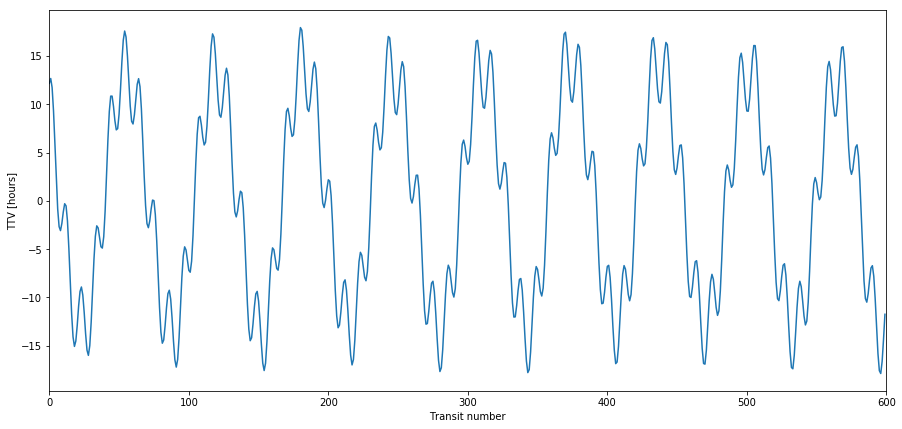

In [16]:
# note that divided by four to offset the doubling in mass above
pplan[3].m /= 4
x3, y3 = calcTTV(pplan)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(x3, y3);
ax.set_xlim([0, 600])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")

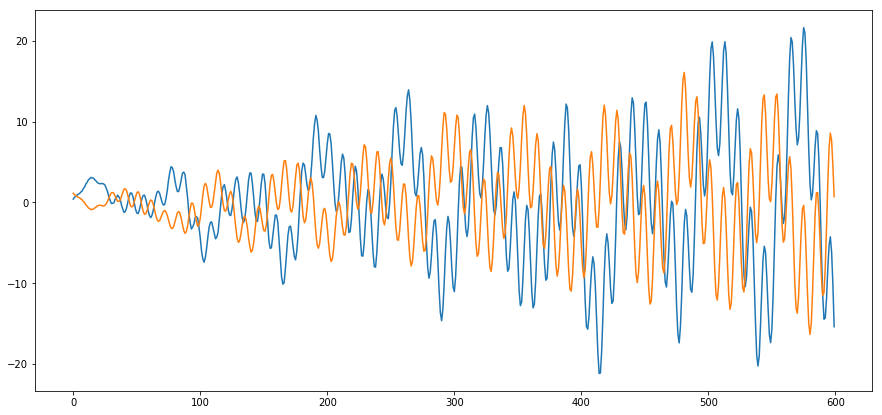

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.plot(x1, y1-y2, label='First - double mass')
ax.plot(x1, y1-y3, label='First - half mass')
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")